<h5 style="color: orange;">Imports</h5>

These are very basic imports needed for the code to run. `matplotlib` is imported later on as I did graph analysis near the end of the project.

In [1]:
import os
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

<h5 style="color: orange;"> Ensuring the GPU is used </h5>

As I painfully realized, the CPU is really slow at fitting the models, and the code must meet certain conditions for the GPU to be use-able by `tensorflow`:

 - `tensorflow`'s version must be less than 2.11, as 2.10.1 is the last version that supports GPUs on native windows without any extra installs/workarounds
 - As I have an Nvidia graphics card (2070 Super), the graphics card must meet minimum computing strength as listed on Nvidia's website, and I must have the graphics driver for my card installed
 - `cudatoolkit` and `cudnn` must be installed

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.1


<h5 style="color: orange;"> Generating the dataframes </h5>

The data are stored in folders which contain all the files associated with the folder's respective sign. To reduce the size of the data, rows not containing data on the left and right hand are dropped, and the entire `row_id` column is dropped. The `frame` column has its values normalized to ensure the frames start at zero and spaced by just one (instead of two, which would be problematic). To further ensure that the dataframes can be properly processed as features, all `nan` values are replaced with -1.

In [3]:
# Get the directory names of the specific signs to test
tested_signs = ["after", "airplane", "all", "alligator", "animal"]
sign_folders = [f"sorted-signs/{sign_name}/" for sign_name in tested_signs]
type_map = {"face": 1, "pose": 2, "left_hand": 3, "right_hand": 4}

# Load the sign to number map
f = open("sign_to_prediction_index_map.json")
sign_dict = json.load(f)
f.close()

# Generate dataframes using the file data
dataframes = []
for sign_folder in sign_folders:
    file_names = os.listdir(sign_folder)

    for file_name in file_names:
        # Read the file
        df = pd.read_parquet(f"{sign_folder}{file_name}")

        # Drop unnecessary values
        df = df[df["type"] != "face"]
        df = df[df["type"] != "pose"]
        df = df.drop("row_id", axis=1)

        # Encode the signs and types
        df["sign"] = tested_signs.index(sign_folder.split("/")[1])
        df["type"] = df["type"].map(type_map)

        # Normalize the frame numbers and limit frames to just first 1000
        df["frame"] = df["frame"] - int(df.iloc[0]["frame"])
        df = df[df["frame"] < 1000]

        # Replace nan with -1 and convert values to float32
        df.fillna(-1, inplace=True)
        df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
        dataframes.append(df)

    print(f"Files for '{sign_folder}' have been processed.")



Files for 'sorted-signs/after/' have been processed.
Files for 'sorted-signs/airplane/' have been processed.
Files for 'sorted-signs/all/' have been processed.
Files for 'sorted-signs/alligator/' have been processed.
Files for 'sorted-signs/animal/' have been processed.


In [4]:
max_length = max(df.shape[0] for df in dataframes)

max_length

17388

<h5 style="color: orange;"> Padding the dataframes </h5>
Specifically for this `keras` model, the shapes of the data must be consistent. This being said, the dataframes must thus be padded to ensure each dataframe's `shape` are the same. The number of columns are guarenteed to be constant, so only more rows are necessary. All dataframes have a number of rows that is divisble by 42 because there are 21 rows for the left hand and 21 rows for the right hand. This means that each dataframe must be padded 42 rows at a time to maintain a consistent pattern and size. 

To distinguish padding (frame never existed) and nan values (the -1 values representing that the frame existed but the hand itself did not show up), `-2` will be the value used for `x`, `y`, and `z`.

In [5]:
# left and right hand dataframe pad template

max_length = max(df.shape[0] for df in dataframes)
print(f"Adjusted (max) length: {max_length}")

for i in range(len(dataframes)):
    # Get relevant data
    df = dataframes[i]
    
    if df.shape[0] < max_length:
        pad_df = pd.DataFrame([{"frame": -2, "type": -2, "landmark_index": -2, "x": -2, "y": -2, "z": -2, "sign": -2} for a in range(max_length - df.shape[0])])
        df = pd.concat([df, pad_df], axis=0)

    # Ensure the values are still in float32 after padding
    df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    dataframes[i] = df

    print(f"{i}/{len(dataframes)} have been padded.")

Adjusted (max) length: 17388
0/1864 have been padded.
1/1864 have been padded.
2/1864 have been padded.
3/1864 have been padded.
4/1864 have been padded.
5/1864 have been padded.
6/1864 have been padded.
7/1864 have been padded.
8/1864 have been padded.
9/1864 have been padded.
10/1864 have been padded.
11/1864 have been padded.
12/1864 have been padded.
13/1864 have been padded.
14/1864 have been padded.
15/1864 have been padded.
16/1864 have been padded.
17/1864 have been padded.
18/1864 have been padded.
19/1864 have been padded.
20/1864 have been padded.
21/1864 have been padded.
22/1864 have been padded.
23/1864 have been padded.
24/1864 have been padded.
25/1864 have been padded.
26/1864 have been padded.
27/1864 have been padded.
28/1864 have been padded.
29/1864 have been padded.
30/1864 have been padded.
31/1864 have been padded.
32/1864 have been padded.
33/1864 have been padded.
34/1864 have been padded.
35/1864 have been padded.
36/1864 have been padded.
37/1864 have been p

<h5 style="color: orange;"> Ensuring consistent number of rows </h5>

This chunk of code ensures that the padding was done appropriately as it shows that the minimum number of rows is the same as the maximum number of rows out of all the dataframes.

In [6]:
final_max_length = max(df.shape[0] for df in dataframes)
final_min_length = min(df.shape[0] for df in dataframes)

final_max_length, final_min_length

(17388, 17388)

<h5 style="color: orange;"> Ensuring label normalization </h5>

This chunk of code ensures that the labels are normalized (which is also necessary for the model to one hot encode them) by showing that the labels are integer values from 0 to 6 (there are seven labels at the moment).

In [7]:
a = set([df["sign"].iloc[0] for df in dataframes])

a

{0, 1, 2, 3, 4}

<h5 style="color: orange;"> Feature Extraction </h5>
The `random` module is finally imported to shuffle the dataframes as all the dataframes are grouped by sign. Separating the dataframes into test and train lists will be problematic if this list is not shuffled. The seed is set to 69 due to a lack of creativity and for consistent shuffling.

The dataframes are looped through and converted into 3D tensors with dimensions of number of datapoints, number of rows, and number of features (in this specific order). The labels are extracted and are one hot encoded. The features are then extracted and placed into `data`.

In [8]:
# Shuffle the data
random.Random(69).shuffle(dataframes)

# Convert dataframes to 3D tensor
data = np.zeros((len(dataframes), dataframes[0].shape[0], 6))
labels = np.zeros((len(dataframes), 5))
for i, df in enumerate(dataframes):
    # Extract label
    label = df.iloc[0, -1]
    labels[i] = to_categorical(label, 5)
    
    # Extract features
    features = df.iloc[:, :-1].values
    data[i, :final_max_length, :] = features

<h5 style="color: orange;">Forming the first model (v1.0)</h5>

This is a very simple RNN utilitizing a Masking layer to ignore the padding, a LSTM layer with 64 neurons, and a Dense layer for the final layer. `categorical_crossentropy` is used as the loss function as this is a multi-class categorical problem with one-hot encoded labels. The optimizer is `adam` and the metric used is accuracy.

In [9]:
model = Sequential()
model.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v1.0 </h5>

In [11]:
model_results = model.fit(data, labels, validation_split=0.1, epochs=100, batch_size=32)

Epoch 1/100
53/53 [==============================] - 14s 270ms/step - loss: 1.6320 - accuracy: 0.2332 - val_loss: 1.5929 - val_accuracy: 0.2567
Epoch 2/100
53/53 [==============================] - 13s 247ms/step - loss: 1.5856 - accuracy: 0.2660 - val_loss: 1.5874 - val_accuracy: 0.2460
Epoch 3/100
53/53 [==============================] - 14s 259ms/step - loss: 1.5773 - accuracy: 0.2743 - val_loss: 1.5889 - val_accuracy: 0.2353
Epoch 4/100
53/53 [==============================] - 18s 347ms/step - loss: 1.5833 - accuracy: 0.2588 - val_loss: 1.5804 - val_accuracy: 0.2353
Epoch 5/100
53/53 [==============================] - 18s 341ms/step - loss: 1.5767 - accuracy: 0.2570 - val_loss: 1.5799 - val_accuracy: 0.2353
Epoch 6/100
53/53 [==============================] - 18s 338ms/step - loss: 1.5769 - accuracy: 0.2594 - val_loss: 1.5791 - val_accuracy: 0.2460
Epoch 7/100
53/53 [==============================] - 15s 285ms/step - loss: 1.5753 - accuracy: 0.2695 - val_loss: 1.5910 - val_accuracy:

<h5 style="color: orange;">Forming the second model</h5>

In an attempt to improve model v1, a second LSTM layer is added (also with 64 neurons).

In [12]:
model2 = Sequential()
model2.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(5, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v2 </h5>

In [13]:
model2_results = model2.fit(data, labels, validation_split=0.1, epochs=100, batch_size=32)

Epoch 1/100
53/53 [==============================] - 35s 503ms/step - loss: 1.5928 - accuracy: 0.2552 - val_loss: 1.5877 - val_accuracy: 0.2460
Epoch 2/100
53/53 [==============================] - 25s 465ms/step - loss: 1.5861 - accuracy: 0.2671 - val_loss: 1.5812 - val_accuracy: 0.2460
Epoch 3/100
53/53 [==============================] - 27s 510ms/step - loss: 1.5844 - accuracy: 0.2618 - val_loss: 1.5865 - val_accuracy: 0.2299
Epoch 4/100
53/53 [==============================] - 27s 510ms/step - loss: 1.5794 - accuracy: 0.2677 - val_loss: 1.5829 - val_accuracy: 0.2246
Epoch 5/100
53/53 [==============================] - 25s 471ms/step - loss: 1.5830 - accuracy: 0.2606 - val_loss: 1.5965 - val_accuracy: 0.2193
Epoch 6/100
53/53 [==============================] - 26s 484ms/step - loss: 1.5765 - accuracy: 0.2600 - val_loss: 1.5751 - val_accuracy: 0.2299
Epoch 7/100
53/53 [==============================] - 25s 468ms/step - loss: 1.5756 - accuracy: 0.2749 - val_loss: 1.5767 - val_accuracy:

<h5 style="color: orange;"> Forming the third model </h5>

In an another attempt to improve model v1, the base LSTM layer now has double the number of neurons.

In [14]:
model3 = Sequential()
model3.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model3.add(LSTM(128, return_sequences=True))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange;"> Training model v3 </h5>

In [15]:
model3_results = model3.fit(data, labels, validation_split=0.1, epochs=100, batch_size=32)

Epoch 1/100
53/53 [==============================] - 42s 623ms/step - loss: 1.6047 - accuracy: 0.2427 - val_loss: 1.5904 - val_accuracy: 0.2086
Epoch 2/100
53/53 [==============================] - 28s 540ms/step - loss: 1.5821 - accuracy: 0.2701 - val_loss: 1.5728 - val_accuracy: 0.2781
Epoch 3/100
53/53 [==============================] - 30s 559ms/step - loss: 1.5863 - accuracy: 0.2618 - val_loss: 1.5893 - val_accuracy: 0.2246
Epoch 4/100
53/53 [==============================] - 30s 568ms/step - loss: 1.5871 - accuracy: 0.2701 - val_loss: 1.5955 - val_accuracy: 0.2406
Epoch 5/100
53/53 [==============================] - 27s 513ms/step - loss: 1.5827 - accuracy: 0.2528 - val_loss: 1.5846 - val_accuracy: 0.2193
Epoch 6/100
53/53 [==============================] - 28s 514ms/step - loss: 1.5786 - accuracy: 0.2654 - val_loss: 1.5849 - val_accuracy: 0.2353
Epoch 7/100
53/53 [==============================] - 28s 520ms/step - loss: 1.5801 - accuracy: 0.2642 - val_loss: 1.6007 - val_accuracy:

<h5 style="color: orange;">Forming the fourth model</h5>

In an attempt to improve model v3, the number of epochs is doubled. Perhaps the model will benefit from more training as historical results indicate underfitting and the model is still learning past 100 epochs. To save time, model v4 will just be model v3 trained with an additional 100 epochs.

In [16]:
model4 = Sequential()
model4.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model4.add(LSTM(128, return_sequences=True))
model4.add(LSTM(64, return_sequences=False))
model4.add(Dense(5, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v4 </h5>

In [17]:
model4_results = model3.fit(data, labels, validation_split=0.1, epochs=100, batch_size=32)

Epoch 1/100
53/53 [==============================] - 30s 564ms/step - loss: 0.4210 - accuracy: 0.8318 - val_loss: 0.9526 - val_accuracy: 0.6578
Epoch 2/100
53/53 [==============================] - 27s 506ms/step - loss: 0.3998 - accuracy: 0.8390 - val_loss: 1.0594 - val_accuracy: 0.6578
Epoch 3/100
53/53 [==============================] - 29s 551ms/step - loss: 0.4021 - accuracy: 0.8450 - val_loss: 0.9957 - val_accuracy: 0.6578
Epoch 4/100
53/53 [==============================] - 28s 519ms/step - loss: 0.4515 - accuracy: 0.8211 - val_loss: 0.9612 - val_accuracy: 0.6898
Epoch 5/100
53/53 [==============================] - 28s 512ms/step - loss: 0.3453 - accuracy: 0.8724 - val_loss: 0.9523 - val_accuracy: 0.7005
Epoch 6/100
53/53 [==============================] - 30s 576ms/step - loss: 0.3322 - accuracy: 0.8742 - val_loss: 1.0007 - val_accuracy: 0.6898
Epoch 7/100
53/53 [==============================] - 28s 518ms/step - loss: 0.3632 - accuracy: 0.8479 - val_loss: 1.0331 - val_accuracy:

<h5 style="color: orange;">Forming the fifth model</h5>

A smaller batch size may be more helpful since there is a lot of data. The batch size is now halved to 16 to see if this is an improvement to v4.

In [18]:
model5 = Sequential()
model5.add(Masking(mask_value=-2, input_shape=(dataframes[0].shape[0], 6)))
model5.add(LSTM(128, return_sequences=True))
model5.add(LSTM(64, return_sequences=False))
model5.add(Dense(5, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<h5 style="color: orange"> Training model v5 </h5>

In [19]:
model5_results = model5.fit(data, labels, validation_split=0.1, epochs=200, batch_size=16)

Epoch 1/200
105/105 [==============================] - 57s 467ms/step - loss: 1.6055 - accuracy: 0.2361 - val_loss: 1.5966 - val_accuracy: 0.2193
Epoch 2/200
105/105 [==============================] - 47s 451ms/step - loss: 1.5887 - accuracy: 0.2582 - val_loss: 1.5865 - val_accuracy: 0.2353
Epoch 3/200
105/105 [==============================] - 46s 431ms/step - loss: 1.5834 - accuracy: 0.2528 - val_loss: 1.5786 - val_accuracy: 0.2674
Epoch 4/200
105/105 [==============================] - 49s 471ms/step - loss: 1.5787 - accuracy: 0.2731 - val_loss: 1.5789 - val_accuracy: 0.2620
Epoch 5/200
105/105 [==============================] - 47s 448ms/step - loss: 1.5828 - accuracy: 0.2660 - val_loss: 1.5949 - val_accuracy: 0.2727
Epoch 6/200
105/105 [==============================] - 70s 669ms/step - loss: 1.5822 - accuracy: 0.2660 - val_loss: 1.5740 - val_accuracy: 0.2781
Epoch 7/200
105/105 [==============================] - 59s 563ms/step - loss: 1.5836 - accuracy: 0.2630 - val_loss: 1.5852 -

<h5 style="color: orange;"> Creating plots for the model histories </h5>

Below is a simple function that takes the history from a model's results and plots the training and validation versions of whatever statistic is given (which is either `accuracy` or `loss`). All these plots are put on the same graph for easier comparison.

In [108]:
from matplotlib import pyplot as plt

def plot_side_by_side_stats(histories, stat, is_val) -> None:
    """ Plots the stat, as seen in the model history, as a function of the epoch number """
    # Title
    type_of_data = "Testing" if not is_val else "Validation"
    plt.title(f"{type_of_data} {stat.capitalize()} of models")

    # Plotting
    for i in range(len(histories)):
        history = histories[i]
        stat_str = f"{'val_' if is_val else ''}{stat}"
        if i != 3:
            plt.plot(history[stat_str])
        else:
            plt.plot(range(101, 201), history[stat_str])

    # Labelling the axes + making legends
    plt.xlabel("Epoch")
    plt.ylabel(f"{stat.capitalize()}")

    legend_location = "lower right" if (stat == "accuracy" or (stat == "loss" and is_val)) else "upper right"
    plt.legend([f"V{i+1}" for i in range(5)], loc=legend_location)

    # Setting the x and y ticks
    max_y_height = 1.1 if stat == "accuracy" else 2.4
    plt.xticks(np.arange(0, 220, 20))    
    plt.yticks(np.arange(0, max_y_height, 0.1))
    
    # Set horizontal line at random chance accuracy
    if stat == "accuracy":
        plt.axhline(y=0.2, color="k", linestyle="--")
    
    plt.axvline(x=100, color="k", linestyle="--")

    # Reveal the graph
    plt.grid()
    plt.show()
    

<h5 style="color: orange;"> Plotting the comparison graphs </h5>

Here, you will see four graphs depciting testing accuracy, validation accuracy, testing loss, and validation loss at each epoch of each of the models. The horizontal dashed line is representing the chance of accuracy (20%) if random chance was used as the model. Since v4 and v5 go past 100 epochs, the vertical dashed line represents the 100 epoch mark to better distinguish the end of v1, v2, and v3. Note that v4 is actually an extension of v3 since v4 is using the trained v3.

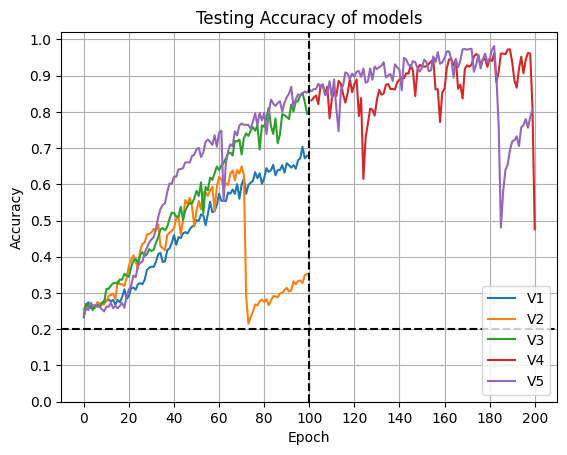

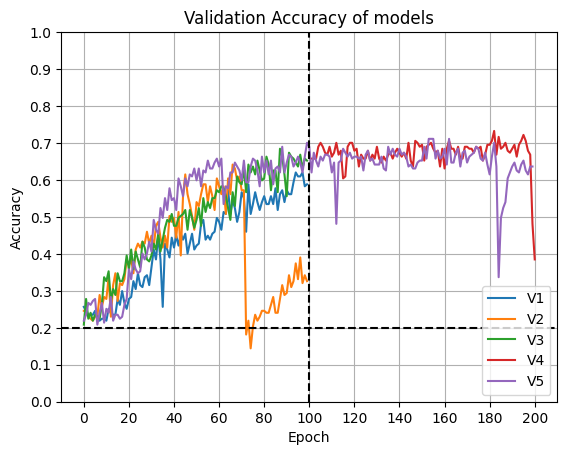

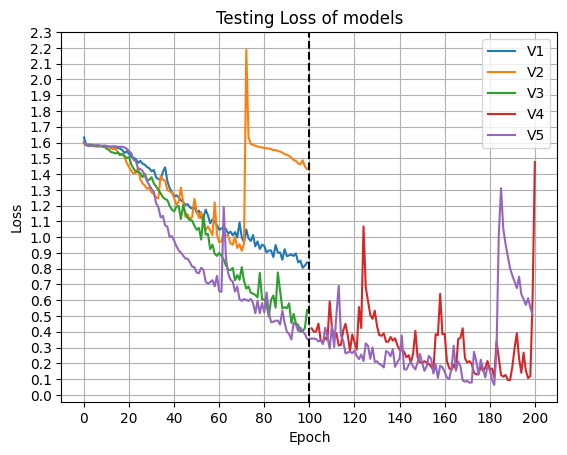

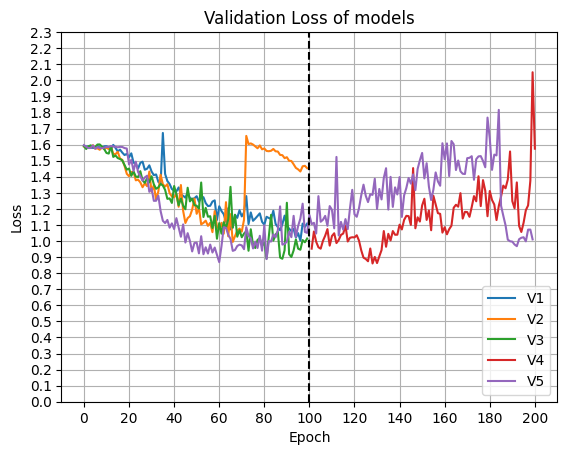

In [109]:
model_histories = {"V1": model_results.history, "V2": model2_results.history,
                   "V3": model3_results.history, "V4": model4_results.history,
                   "V5": model5_results.history}

plot_side_by_side_stats(list(model_histories.values()), "accuracy", False)
plot_side_by_side_stats(list(model_histories.values()), "accuracy", True)
plot_side_by_side_stats(list(model_histories.values()), "loss", False)
plot_side_by_side_stats(list(model_histories.values()), "loss", True)

<h5 style="color: orange;"> Creating per model graphs </h5>

Now, time to make graphs representing both accuracies and both losses but on a per model basis. Also the testing and validation data will be put on the same graph, therefore, each model will have one graph depicting the testing and validation accuracies and another graph depicting the testing and validation losses.

In [130]:
def plot_stat(history, name: str) -> None:
    """ Plots the stat, as seen in the model history, as a function of the epoch number """

    model_index = int(name[1]) - 1

    fig, axes = plt.subplots(2)
    stats = ["accuracy", "loss"]

    for i in range(len(axes)):
        ax = axes[i]
        stat = stats[i]

        # Title
        ax.set_title(f"{stat.capitalize()} of model {name}")

        # Plotting
        ax.plot(history[stat])
        ax.plot(history[f"val_{stat}"])

        # Labelling the axes + making legends
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{stat.capitalize()}")

        # Dyanimically adjust x ticks
        starts = [0, 0, 0, 100, 0]
        endings = [105, 105, 105, 205, 210]
        steps = [5, 5, 5, 10, 20]

        start, ending, x_step = starts[model_index], endings[model_index], steps[model_index]
        ax.set_xticks(np.arange(0, (ending - start), x_step), np.arange(start, ending, x_step))
        
        # Dynamically adjust y ticks
        random_chance_adjusted = 0.16 if stat == "accuracy" else 1
        low = min(min(history[stat]), min(history[f"val_{stat}"]), random_chance_adjusted)
        high = max(max(history[stat]), max(history[f"val_{stat}"]))
        y_step = (high - low) / 7
        ax.set_yticks(np.arange(low, high + y_step, y_step))
        
        # Set horizontal line at random chance accuracy
        if stat == "accuracy":
            ax.axhline(y=0.2, color="k", linestyle="--")

        # Legend + grid
        ax.grid()
        legend_postion = "upper left" if ((name == "V4" and stat == "loss") or (name != "V4" and stat == "accuracy")) else "lower left"
        ax.legend(["train", "val"], loc=legend_postion)

    # Reveal the graph
    fig.tight_layout()
    plt.show()

<h5 style="color: orange;"> Plotting the individual model graphs </h5>

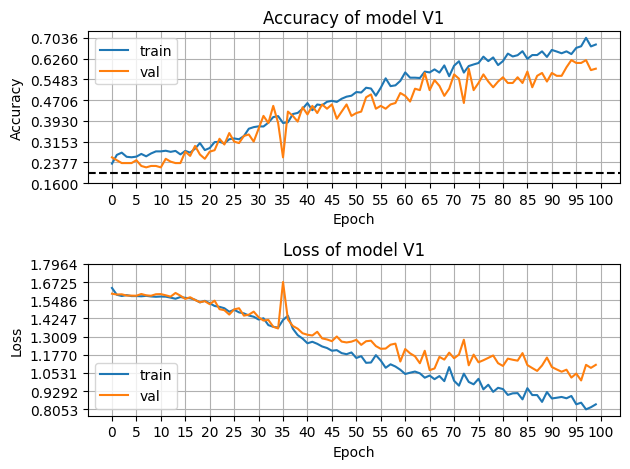

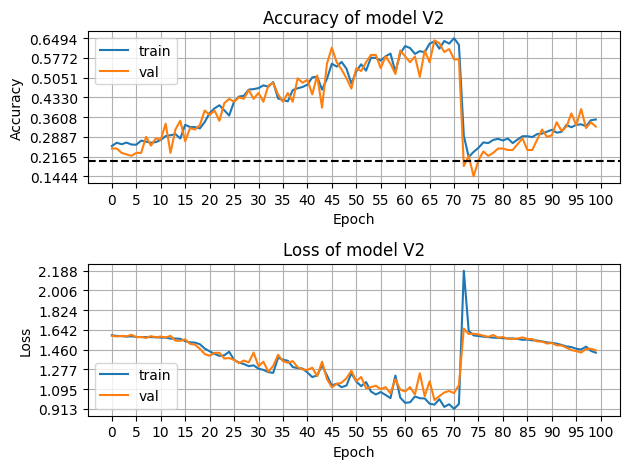

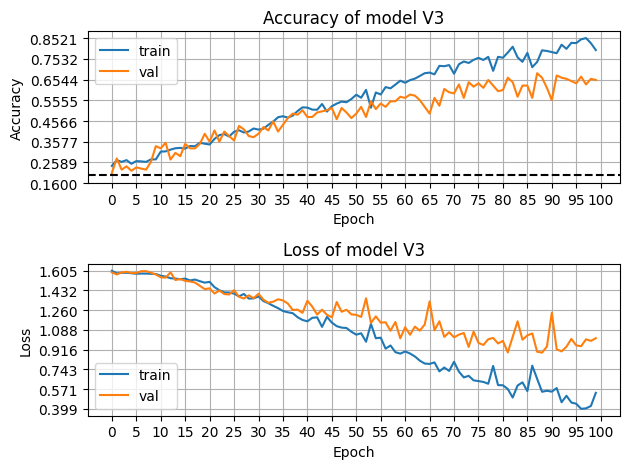

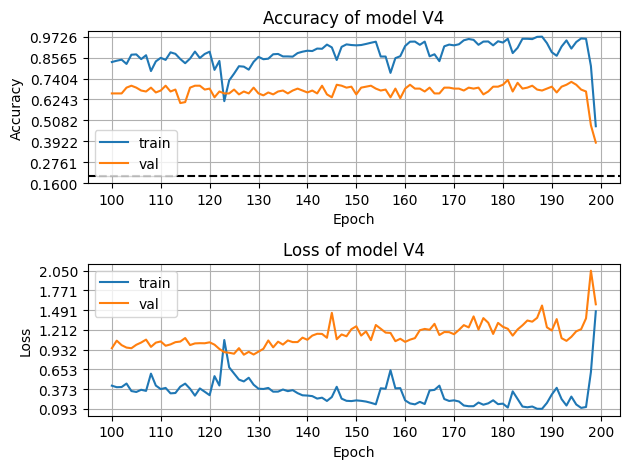

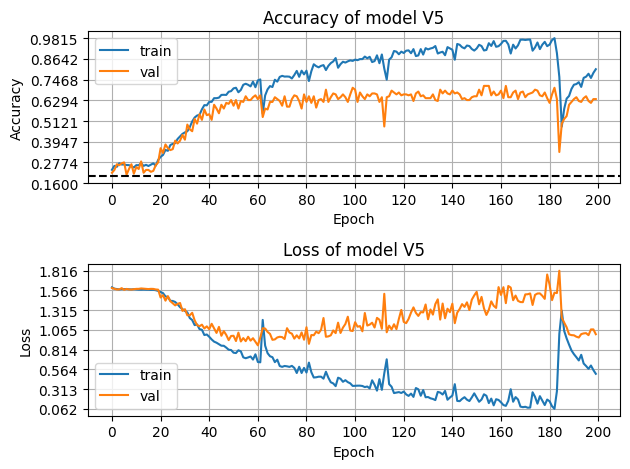

In [131]:
for model_version in model_histories:
    plot_stat(model_histories[model_version], model_version)

<h5 style="color: orange;"> More analysis of the graphs </h5>

A more numeric approach will be used to analyze the models. The following data will be collected and displayed in four tables (one table each for the two accuracies (training and validation sets) and one table  each for the two losses (training and validation sets)):

 - Model name
 - Start and end accuracy
 - Minimum, maximum, and average accuracy
 - Standard deviation of the accuracy
 - Start and end loss
 - Minimum, maximum, and average loss
 - Standard deviation of the loss

 Four more tables are created to rank the models as either highest or lowest in the respective categories (one table each for the two accuracies (training and validation sets) and one table  each for the two losses (training and validation sets)).

In [40]:
# Function for generating the data table
def generate_info_df(models, stat: str, is_training: bool) -> list[pd.DataFrame]:
    """ Generate a Pandas DataFrame to store numeric information about a specific statistic in regards to a specific model history.
        Also generates a Pandas DataFrame to rank the models."""

    # Dict of data to hold the models' statistics
    information = {"Model Name": [], "Start": [], "End": [],
                   "Min": [], "Max": [], "Avg": [], "Stdev": []}
    
    # Obtain information of all the models
    for model_version in models:
        # Add the name
        information["Model Name"].append(model_version)

        # Extract the information of the model into the dictionary
        stat_label = '' if is_training else 'val_'
        full_stat = f"{stat_label}{stat}"

        accuracies = list(model_histories[model_version][full_stat])
        information["Start"].append(accuracies[0])
        information["End"].append(accuracies[-1])
        information["Min"].append(min(accuracies))
        information["Max"].append(max(accuracies))
        information["Avg"].append(f"{sum(accuracies) / len(accuracies) : .4f}")
        information["Stdev"].append(np.std(accuracies))

    # Create the stats dataframe
    stats_df = pd.DataFrame(information)

    # Dict of data to hold the highest and lowest ranking models
    ranks = {"": ["Highest", "Lowest"], "Start": [], "End": [], 
             "Min": [], "Max": [], "Avg": [], "Stdev": []}
    
    # Populate the ranks dict
    for stat in ranks.keys():
        # Skips the first placeholder column
        if stat in information.keys():
            # Extract the model names
            model_stats = information[stat]
            highest_model = f"V{model_stats.index(max(model_stats)) + 1}"
            lowest_model = f"V{model_stats.index(min(model_stats)) + 1}"

            ranks[stat].append(highest_model)
            ranks[stat].append(lowest_model)

    # Create the ranks dataframe
    ranks_df = pd.DataFrame(ranks)

    # Return the values
    return stats_df, ranks_df


# Generating the tables
stat_train_acc, rank_train_acc = generate_info_df(model_histories, "accuracy", True)
stat_val_acc, rank_val_acc = generate_info_df(model_histories, "accuracy", False)
stat_train_loss, rank_train_loss = generate_info_df(model_histories, "loss", True)
stat_val_loss, rank_val_loss = generate_info_df(model_histories, "loss", False)


In [41]:
print("Accuracy statistics (training dataset)")
stat_train_acc


Accuracy statistics (training dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,0.233154,0.678593,0.233154,0.703637,0.4736,0.142578
1,V2,0.255218,0.352415,0.215265,0.649374,0.4093,0.128704
2,V3,0.242695,0.794872,0.242695,0.852117,0.5582,0.184542
3,V4,0.831843,0.475850,0.475850,0.972570,0.8814,0.071692
4,V5,0.236136,0.805605,0.236136,0.981515,0.7364,0.218137


In [42]:
print("Accuracy rankings (training dataset)")
rank_train_acc


Accuracy rankings (training dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V4,V5,V4,V5,V4,V5
1,Lowest,V1,V2,V2,V2,V2,V4


In [43]:
print("Accuracy statistics (validation dataset)")
stat_val_acc


Accuracy statistics (validation dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,0.256684,0.588235,0.219251,0.620321,0.4277,0.122624
1,V2,0.245989,0.326203,0.144385,0.641711,0.3964,0.133060
2,V3,0.208556,0.652406,0.208556,0.684492,0.4884,0.131142
3,V4,0.657754,0.385027,0.385027,0.732620,0.6723,0.040972
4,V5,0.219251,0.636364,0.208556,0.711230,0.5799,0.134981


In [44]:
print("Accuracy rankings (validation dataset)")
rank_val_acc

Accuracy rankings (validation dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V4,V3,V4,V4,V4,V5
1,Lowest,V3,V2,V2,V1,V2,V4


In [45]:
print("Loss statistics (training dataset)")
stat_train_loss


Loss statistics (training dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,1.632009,0.839467,0.805284,1.632009,1.2131,0.259718
1,V2,1.592843,1.431383,0.913056,2.188322,1.3616,0.231335
2,V3,1.604737,0.538398,0.398922,1.604737,1.0500,0.383249
3,V4,0.421017,1.475321,0.093391,1.475321,0.3198,0.192087
4,V5,1.605494,0.507309,0.062469,1.605494,0.6405,0.471185


In [46]:
print("Loss rankings (training dataset)")
rank_train_loss

Loss rankings (training dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V1,V4,V2,V2,V2,V5
1,Lowest,V4,V5,V5,V4,V4,V4


In [47]:
print("Loss statistics (validation dataset)")
stat_val_loss


Loss statistics (validation dataset)


,Model Name,Start,End,Min,Max,Avg,Stdev
0,V1,1.592873,1.108457,1.002173,1.672529,1.3082,0.186046
1,V2,1.587735,1.453384,0.994310,1.654092,1.3772,0.188764
2,V3,1.590435,1.015591,0.889575,1.601071,1.2365,0.216304
3,V4,0.952590,1.574637,0.860290,2.050292,1.1352,0.173647
4,V5,1.596600,1.010285,0.868658,1.816204,1.2449,0.227468


In [48]:
print("Loss rankings (validation dataset)")
rank_val_loss


Loss rankings (validation dataset)


,,Start,End,Min,Max,Avg,Stdev
0,Highest,V5,V4,V1,V4,V2,V5
1,Lowest,V4,V5,V4,V3,V4,V4
